In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from src.utils.data_utils import TGIF
from src.utils.trainer import ModelTrainer

from src.models.vae import VAE, Initializer

import numpy as np
import os

%load_ext autoreload
%autoreload 2


TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'vae-test')

In [2]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

def lstm_flatten(x):
    B, T = x.shape[0], x.shape[1]
    return x.view(B, T, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [3]:
def deprocess(img):
    transform = transforms.Compose([
        transforms.Lambda(rescale),
    ])
    return transform(img)

def rescale(x):
low, high = x.min(), x.max()
x_rescaled = (x - low) / (high - low)
return x_rescaled


In [4]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [2]:
IMAGE_SZ = (64, 64)
BATCH_SZ = 64
batch_size = BATCH_SZ
NUM_WORKERS = 4

NUM_TRAIN = 50000
NUM_VAL = 5000



class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

# DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/TGIF/GIFs/'
DATASET_ROOT = './src/datasets/CIFAR10'


transform=transforms.Compose([
        transforms.Resize(IMAGE_SZ), # standardize size
        transforms.ToTensor(),       # conver to tensor between 0...1
                                     # TODO: subtract mean 
                                     # have fixed frame size somehow
    ])

mnist_train = dset.MNIST(DATASET_ROOT, train=True, download=True,
                           transform=transform)
loader_train = DataLoader(mnist_train, batch_size=BATCH_SZ,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST(DATASET_ROOT, train=True, download=True,
                           transform=transform)
loader_val = DataLoader(mnist_val, batch_size=BATCH_SZ,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))




MAX_FRAMES = 10


gif_train_set = TGIF(
    root='./src/datasets/TGIF/GIFs/train',
#     root='./src/datasets/GGIF/GIFs/nature/train',    
    preload=False,                    # careful: will load all into memory
    max_frames=MAX_FRAMES,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SZ), # standardize size
        transforms.ToTensor(),       # conver to tensor between 0...1
                                     # TODO: subtract mean 
                                     # have fixed frame size somehow
    ]),
)

gif_train_loader = DataLoader(gif_train_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

Processing...
Done!


In [5]:
print(torch.max(mnist_train[0][0]))

tensor(0.9922)


torch.Size([64, 3, 64, 64])


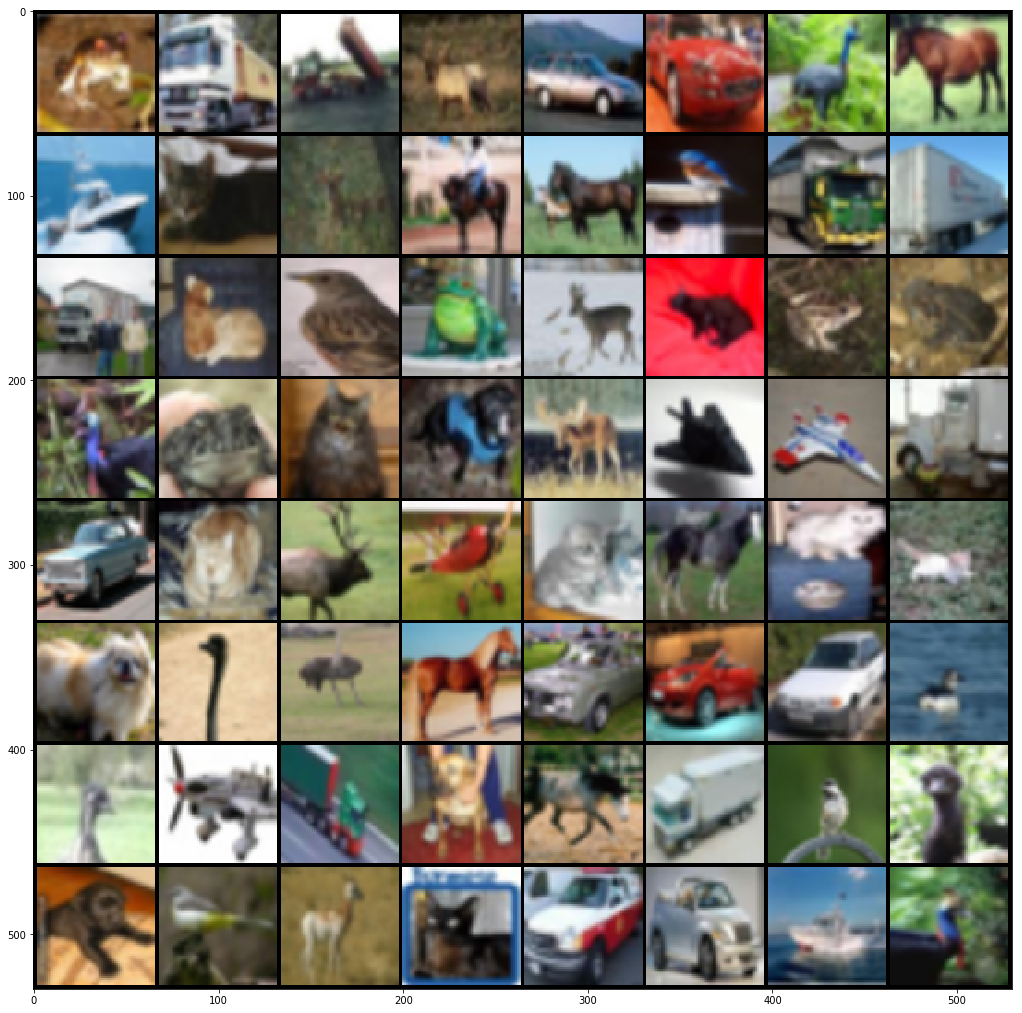

In [43]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 18.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 


def imshow(img, save_file=None):
    npimg = img.numpy()
    out = np.transpose(npimg, (1, 2, 0))

    if save_file:
        plt.imsave(save_file, out)
        
    plt.imshow(out)
    

    
# imgs = loader_train.__iter__().next()[0].view(batch_size, 64*64).numpy().squeeze()
# show_images(imgs)
z = loader_train.__iter__().next()[0]
print(z.shape)
imshow(torchvision.utils.make_grid(z))



In [94]:


def train_fn(model, optimizer, inp):
    
    def loss_fn(recon_x, x, mu, logvar):
        
#         def mse_loss(inp, target):
#             return torch.sum((inp - target) ** 2) / inp.shape[0]
            
        mse_loss = nn.MSELoss(size_average=False)

        MSE = mse_loss(recon_x, x)
        

        # see Appendix B from VAE paper:    https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#         KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD
    

    
    model.train()         
    
    x = inp[0]
    x = x.to(device=device, dtype=dtype)

    recon_x, mu, logvar = model(x)
    
#     print('---', x.shape, recon_x.shape)

    loss = loss_fn(recon_x, x, mu, logvar)

    loss.cuda().backward()
    optimizer.step()
    
    optimizer.zero_grad()
    
    return loss.item()

## Train network

In [99]:
NUM_CHANNELS = 3
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS   
HIDDEN_SIZE = INPUT_SIZE
OUTPUT_SIZE = INPUT_SIZE


net = VAE(latent_size=1024, num_channels=NUM_CHANNELS, device=device)
Initializer.initialize(model=net, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))

# optimizer = optim.SGD(net.parameters(), lr=1e-6, momentum=0.9, nesterov=True)
optimizer = optim.Adam(net.parameters(), lr=2e-4)

trainer = ModelTrainer(net, optimizer, train_fn, TEST_MODEL_PATH, save_models=False)

In [110]:
# optimizer = optim.Adam(net.parameters(), lr=1e-5)
# trainer.update_optimizer(optimizer)


try:
    print('Starting training...')
    trainer.train(loader_train, epochs=1, save_every=100, print_every=50)
except KeyboardInterrupt:
    print("Force saving")
    trainer.save_data(force_save=True)

Starting training...
Epoch [0] (0/782), loss = 22556.091797
Epoch [0] (50/782), loss = 22296.863281
Epoch [0] (100/782), loss = 21170.054688
Epoch [0] (150/782), loss = 19887.398438
Epoch [0] (200/782), loss = 21806.824219
Epoch [0] (250/782), loss = 20684.019531
Epoch [0] (300/782), loss = 19379.935547
Epoch [0] (350/782), loss = 20864.099609
Epoch [0] (400/782), loss = 20943.679688
Epoch [0] (450/782), loss = 20423.292969
Epoch [0] (500/782), loss = 17823.572266
Epoch [0] (550/782), loss = 20172.316406
Epoch [0] (600/782), loss = 19588.394531
Epoch [0] (650/782), loss = 20151.531250
Epoch [0] (700/782), loss = 18800.382812
Epoch [0] (750/782), loss = 22800.222656


In [107]:
# trainer.save_models = True
# trainer.save_data()

# trainer = ModelTrainer(net, optimizer, train_fn, TEST_MODEL_PATH, save_models=False)
# trainer.load_model('1527678163.4640102')

Evaluation mode: just returning mean
torch.Size([64, 3, 64, 64]) torch.Size([64, 3, 64, 64])


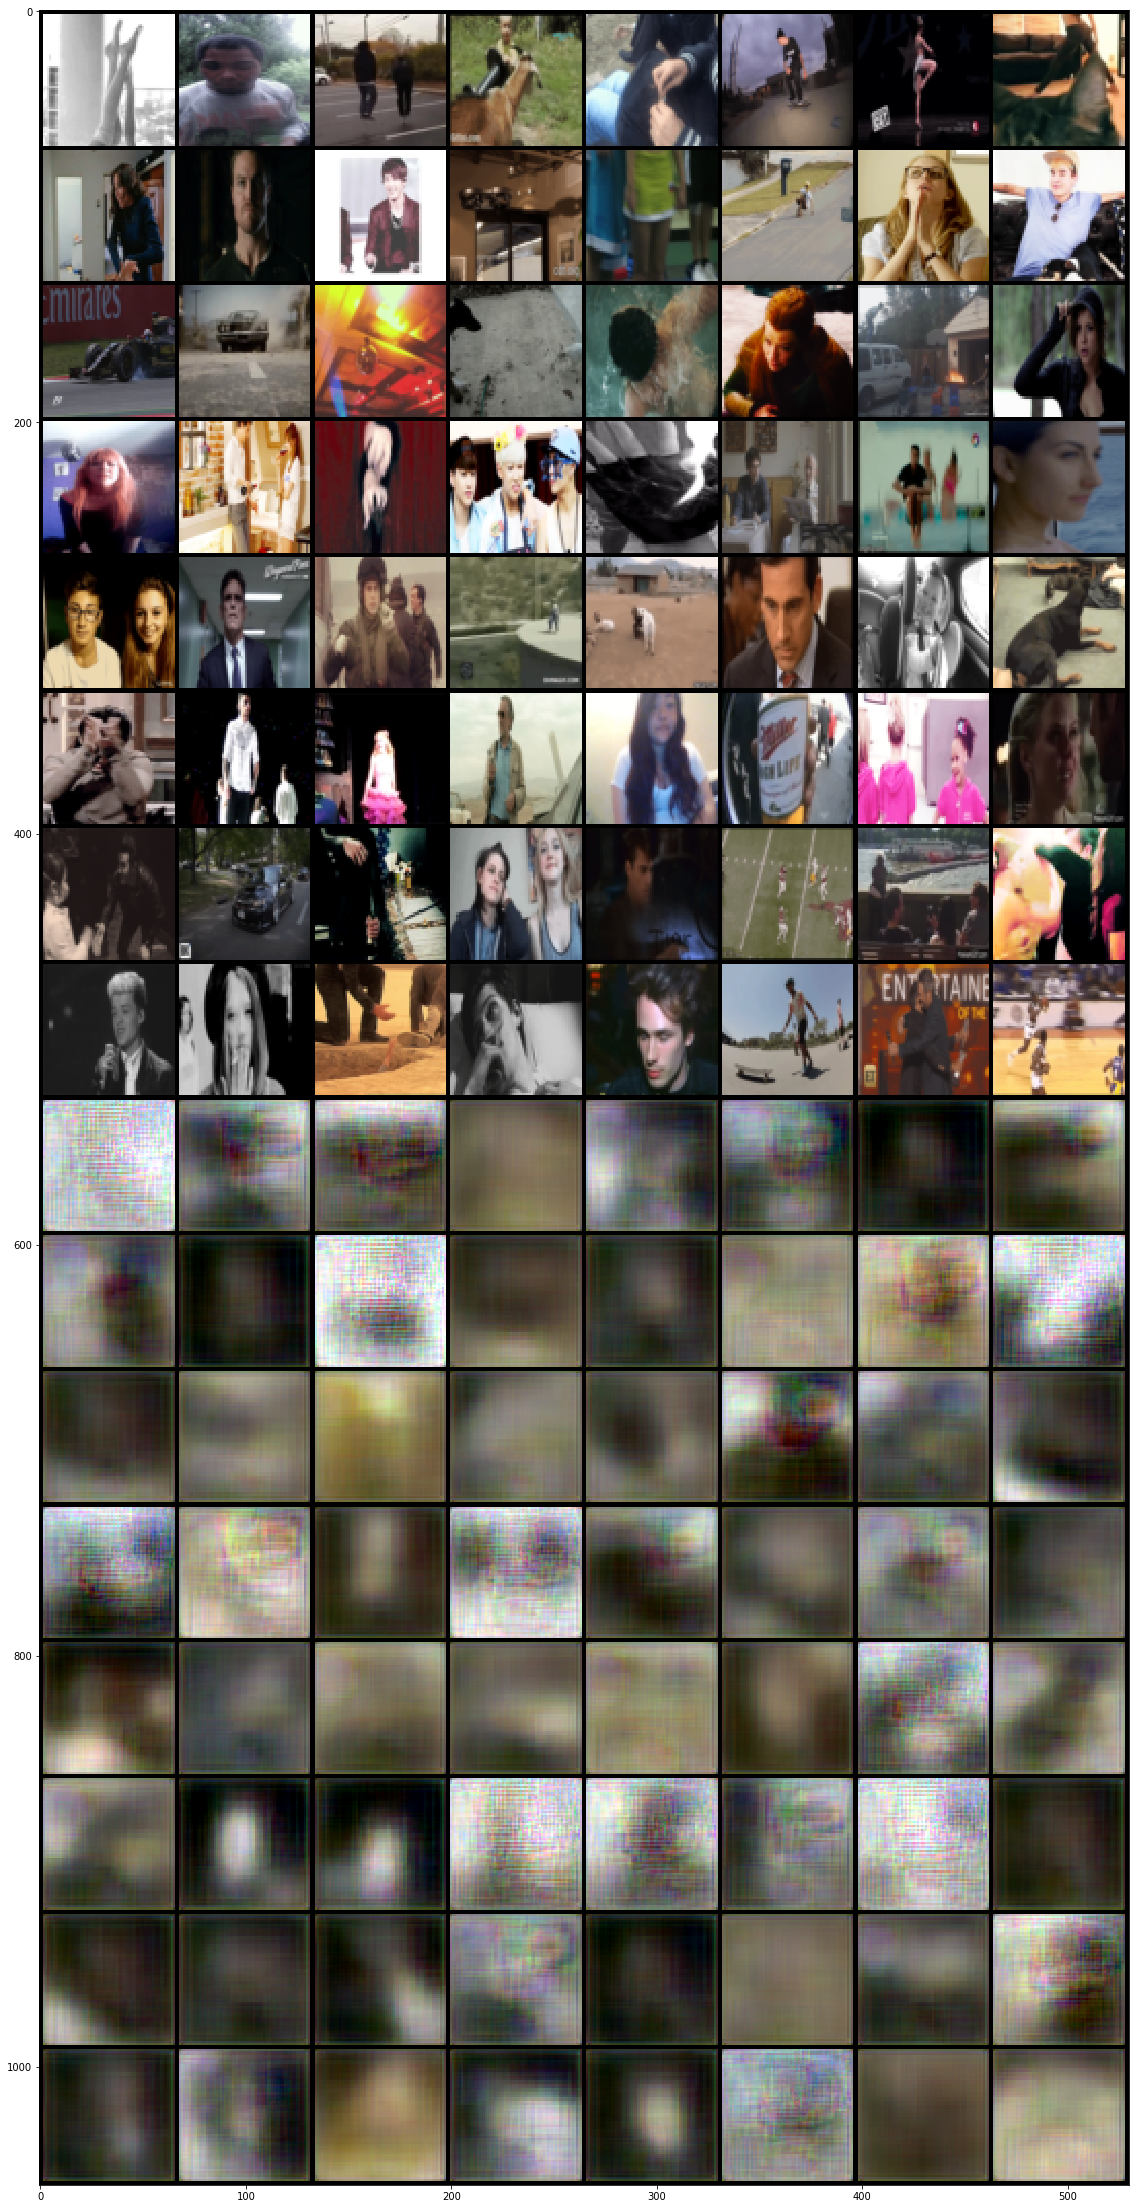

In [108]:
def sample(model, seed_frame, gif_length=10):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    model.eval()
    ret = [seed_frame]
    
    for i in range(gif_length - 1):
        y, curr_h = model(curr_x, curr_h)
        curr_x = y   # TODO: maybe sample from probability?
        ret.append(y.to(device = torch.device('cpu')))
        
    
    return torch.stack(ret).transpose(0, 1)


plt.figure(figsize=(20,40))

    
def test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    
    x = x[0]

    x = x.to(device=device, dtype=dtype)

    
    
    y, mu, logvar = model(x)

    
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
#     y = deprocess(y.to(torch.device('cpu')).detach())
    
    
    imgs = torch.cat([x, y])
    

#     plt.subplot(211)
#     imshow(torchvision.utils.make_grid(x)) #, save_file='img/train_test_orig.png')
#     plt.subplot(212)
    
#     imshow(torchvision.utils.make_grid(y)) #, save_file='img/train_test_out.png')
#     show_images(imgs)
    imshow(torchvision.utils.make_grid(imgs)) #, save_file='img/train_test_out.png')
    
    
    
    
def test_autoenc_gif(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    
    x = x[:, 0, :, :, :]

    x = x.to(device=device, dtype=dtype)
    


    
    
    y, mu, logvar = model(x)
    
    print(x.shape, y.shape)
    
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
#     y = deprocess(y.to(torch.device('cpu')).detach())
    
    
    imgs = torch.cat([x, y])
    imshow(torchvision.utils.make_grid(imgs)) #, save_file='img/train_test_out.png')
        

# test_autoenc(net, loader_train)
test_autoenc_gif(net, gif_train_loader)


## Varying Latent Space

Evaluation mode: just returning mean
torch.Size([64, 1024])


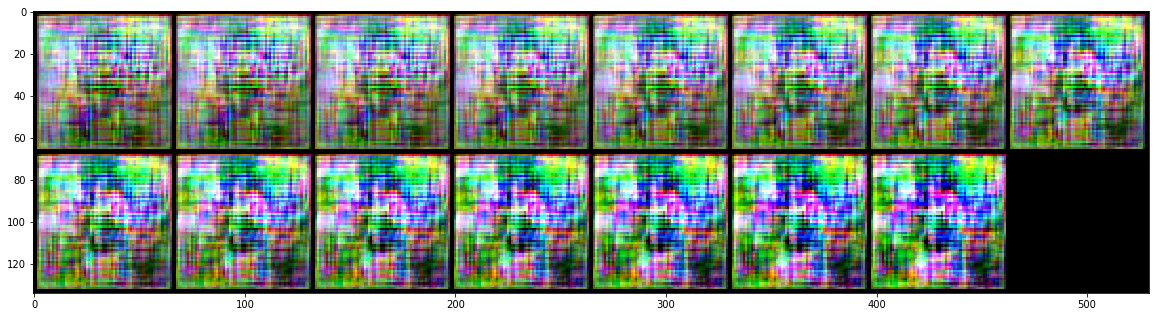

In [103]:
def vary_latent(init_z, step, length, dim, model):
    print(init_z.shape)
    ret = []
    curr_z = init_z.clone()
    curr_z = curr_z.to(device=device)
    
    curr_z[dim] -= step*(length // 2)
    
    model.eval()
    for i in range(length):
        curr_z[:, dim] += step
        y = model.decoder(curr_z)
        y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
        ret.append(y[15])
    
    imshow(torchvision.utils.make_grid(torch.stack(ret)))
        
        
    

def get_latent_z(model, x):
    enc_y = model.encoder(x)
    mu, logvar = model.fc_mu(enc_y), model.fc_logvar(enc_y)
    return model.sample_latent(mu, logvar)


def sample_forward(model, z):
    return model.decoder(z)


def test_varying(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()    
    x = x[0]
    x = x.to(device=device, dtype=dtype)

    z = get_latent_z(net, x)
    vary_latent(z, 5, 15, 10, net)
    
test_varying(net, loader_train)